In [3]:
from typing import List, Tuple
from PIL import Image, ImageDraw, ImageOps
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pytesseract
from tqdm import tqdm

# Ensure pytesseract is properly configured
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'  # Update the path as needed

# Custom Dataset Loading (EMNIST Dataset)
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader

# Load EMNIST dataset filtered for uppercase letters and digits
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = EMNIST(root='./data', split='byclass', train=True, download=True, transform=transform)

# Filter and remap labels to fit within our 36 classes (0-9, A-Z)
filtered_dataset = []
for image, label in tqdm(dataset):
    if 48 <= label <= 57:  # Digits (0-9)
        filtered_label = label - 48  # Remap to 0-9
        filtered_dataset.append((image, filtered_label))
    elif 65 <= label <= 90:  # Uppercase letters (A-Z)
        filtered_label = label - 55  # Remap to 10-35
        filtered_dataset.append((image, filtered_label))

train_loader = DataLoader(filtered_dataset, batch_size=64, shuffle=True)

# Define the Convolutional Neural Network
class CharacterRecognitionNet(nn.Module):
    def __init__(self):
        super(CharacterRecognitionNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 36)  # 36 output classes (10 digits + 26 uppercase letters)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Train the Model
net = CharacterRecognitionNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
	running_loss = 0.0
	for images, labels in tqdm(train_loader):
		images, labels = images.to(device), labels.to(device)
		optimizer.zero_grad()
		outputs = net(images)
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()
		running_loss += loss.item()
	print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Save the Trained Model
torch.save(net.state_dict(), 'character_recognition_model.pth')

Using device: cuda


100%|██████████| 986/986 [00:05<00:00, 185.88it/s]


Epoch [1/5], Loss: 0.2132


100%|██████████| 986/986 [00:05<00:00, 186.14it/s]


Epoch [2/5], Loss: 0.0813


100%|██████████| 986/986 [00:05<00:00, 185.67it/s]


Epoch [3/5], Loss: 0.0616


100%|██████████| 986/986 [00:05<00:00, 185.43it/s]


Epoch [4/5], Loss: 0.0509


100%|██████████| 986/986 [00:05<00:00, 178.60it/s]


Epoch [5/5], Loss: 0.0423


In [9]:
# Load EMNIST test dataset filtered for uppercase letters and digits
test_dataset = EMNIST(root='./data', split='byclass', train=False, download=True, transform=transform)

# Filter and remap labels to fit within our 36 classes (0-9, A-Z)
filtered_test_dataset = []
for image, label in tqdm(test_dataset):
	if 48 <= label <= 57:  # Digits (0-9)
		filtered_label = label - 48  # Remap to 0-9
		filtered_test_dataset.append((image, filtered_label))
	elif 65 <= label <= 90:  # Uppercase letters (A-Z)
		filtered_label = label - 55  # Remap to 10-35
		filtered_test_dataset.append((image, filtered_label))

test_loader = DataLoader(filtered_test_dataset, batch_size=64, shuffle=False)

100%|██████████| 116323/116323 [00:19<00:00, 5835.97it/s]


In [10]:
# test
net = CharacterRecognitionNet().to(device)
net.load_state_dict(torch.load('character_recognition_model.pth'))
net.eval()

correct = 0
total = 0
with torch.no_grad():
	for images, labels in tqdm(test_loader):
		images, labels = images.to(device), labels.to(device)
		outputs = net(images)
		_, predicted = torch.max(outputs.data, 1)
		total += labels.size(0)
		correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

/tmp/ipykernel_113132/2577644477.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('character_recognition_model.pth'))
100%|██████████| 163/

Accuracy: 98.02%


In [20]:
def preprocess_image(image_path: str) -> torch.Tensor:
	image = Image.open(image_path).convert('L')  # Convert to grayscale first
	image = ImageOps.invert(image)
	image = image.resize((28, 28))
	
	# Apply binarization
	image = np.array(image)
	_, image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
	
	# Apply erosion
	kernel = np.ones((3, 3), np.uint8)
	image = cv2.erode(image, kernel, iterations=1)
	
	image = Image.fromarray(image)
	image = transforms.ToTensor()(image)
	image = transforms.Normalize((0.5,), (0.5,))(image)
	return image

def predict_image(image_path: str, model: nn.Module) -> str:
	image = preprocess_image(image_path).to(device)  # Move image to the same device as the model
	image = image.unsqueeze(0)
	output = model(image)
	_, predicted = torch.max(output.data, 1)
	return chr(predicted.item() + 55) if predicted.item() >= 10 else str(predicted.item())

image_path = 'example.png'
predicted_character = predict_image(image_path, net)
print(f'Predicted character: {predicted_character}')

def show_image(image_path: str):
	# apply same preprocessing and show
	image = Image.open(image_path).convert('L')
	image = ImageOps.invert(image)
	image = image.resize((28, 28))
	
	# Apply binarization
	image = np.array(image)
	_, image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
	
	# Apply erosion
	kernel = np.ones((3, 3), np.uint8)
	image = cv2.erode(image, kernel, iterations=1)
	
	image = Image.fromarray(image)
	return image

show_image(image_path)

Predicted character: 2


Predicted character: 1
Correct character: 1


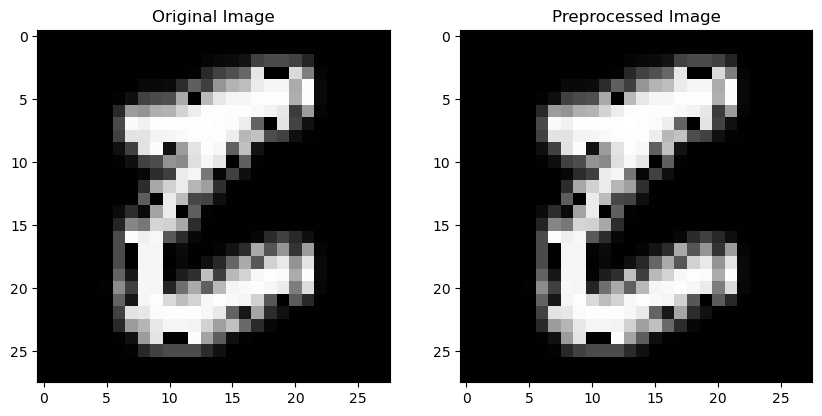

In [33]:
import matplotlib.pyplot as plt

# Define the preprocessing function
def preprocess_image(image: Image.Image) -> torch.Tensor:
	# image = image.convert('L')  # Convert to grayscale first
	# image = ImageOps.invert(image)
	# image = image.resize((28, 28))
	
	# # Apply binarization
	# image = np.array(image)
	# _, image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
	
	# # Apply erosion
	# kernel = np.ones((3, 3), np.uint8)
	# image = cv2.erode(image, kernel, iterations=1)
	
	# image = Image.fromarray(image)
	image = transforms.ToTensor()(image)
	image = transforms.Normalize((0.5,), (0.5,))(image)
	return image

# Define the prediction function
def predict_image(image: Image.Image, model: nn.Module) -> str:
	image = preprocess_image(image).to(device)  # Move image to the same device as the model
	image = image.unsqueeze(0)
	output = model(image)
	_, predicted = torch.max(output.data, 1)
	return chr(predicted.item() + 55) if predicted.item() >= 10 else str(predicted.item())

# Get a single image from the test set
test_image, test_label = next(iter(test_loader))
i = 5

# Convert the tensor image to PIL image for display
test_image_pil = transforms.ToPILImage()(test_image[i].squeeze(0))

# Predict the character
predicted_character = predict_image(test_image_pil, net)
correct_character = chr(test_label[i].item() + 55) if test_label[i].item() >= 10 else str(test_label[i].item())
print(f'Predicted character: {predicted_character}')
print(f'Correct character: {correct_character}')

# Show the preprocessed image
def show_image(image: Image.Image):
	# Apply the same preprocessing and show
	# image = image.convert('L')
	# image = ImageOps.invert(image)
	# image = image.resize((28, 28))
	
	# # Apply binarization
	# image = np.array(image)
	# _, image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
	
	# # Apply erosion
	# kernel = np.ones((3, 3), np.uint8)
	# image = cv2.erode(image, kernel, iterations=1)
	
	# image = Image.fromarray(image)
	return image

# Display the original and preprocessed images
original_image = transforms.ToPILImage()(test_image[i].squeeze(0))
preprocessed_image = show_image(test_image_pil)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Preprocessed Image")
plt.imshow(preprocessed_image, cmap='gray')
plt.show()

---

In [55]:
from PIL import Image, ImageDraw, ImageFont
import os

# Directory setup for dataset
output_dir = "./custom_dataset"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Path to your .ttf file
font_path = "Datasets/Recognition/Generate Dataset/alte-din-1451-mittelschrift/din1451alt.ttf"
font_size = 70

# Load font
font = ImageFont.truetype(font_path, font_size)

# Generate images for each character
characters = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"

for char in tqdm(characters):
	char_dir = os.path.join(output_dir, char)
	if not os.path.exists(char_dir):
		os.makedirs(char_dir)

	# Generate multiple samples for data augmentation
	for i in range(50):  # Create 50 variants of each character
		image = Image.new("L", (64, 64), color=0)  # Black background
		draw = ImageDraw.Draw(image)
		text_bbox = font.getbbox(char)  # Fix: Use font.getbbox instead of font.getsize

		# Calculate position to center the character
		text_x = (image.width - (text_bbox[2] - text_bbox[0])) / 2
		text_y = (image.height - (text_bbox[3] - text_bbox[1])) / 2 - text_bbox[1]  # Adjust text_y to center vertically

		draw.text((text_x, text_y), char, fill=255, font=font)  # White character

		# Save generated character image
		image.save(f"{char_dir}/{char}_{i}.png")


100%|██████████| 36/36 [00:01<00:00, 32.19it/s]


In [56]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import glob
import numpy as np

# Define augmentations to apply
augmentations = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.7),
    A.GaussianBlur(blur_limit=(3, 5), p=0.5)
])

# Load images and apply augmentations
for char in tqdm("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"):
    char_dir = os.path.join(output_dir, char)
    image_paths = glob.glob(f"{char_dir}/*.png")
    
    for image_path in image_paths:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            augmented = augmentations(image=img)
            aug_img = augmented["image"]

            # Ensure the image is properly inverted and converted to uint8
            aug_img = np.clip(aug_img, 0, 255).astype(np.uint8)

            # Save augmented images
            save_path = image_path.replace(".png", ".png")
            cv2.imwrite(save_path, aug_img)

100%|██████████| 36/36 [00:02<00:00, 13.33it/s]


In [65]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from pathlib import Path
import random

class CustomCharDataset(Dataset):
	def __init__(self, root_dir, transform=None):
		self.root_dir = Path(root_dir)
		self.transform = transform
		self.image_paths = list(self.root_dir.glob('*/*.png'))
		self.labels = {char: idx for idx, char in enumerate(characters)}

	def __len__(self):
		return len(self.image_paths)

	def __getitem__(self, idx):
		img_path = self.image_paths[idx]
		image = Image.open(img_path).convert("L")  # Convert to grayscale
		label = self.labels[img_path.parent.name]

		if self.transform:
			image = self.transform(image)

		return image, label

transform = transforms.Compose([
	transforms.Resize((28, 28)),
	transforms.ToTensor(),
	transforms.Normalize((0.5,), (0.5,))
])

dataset = CustomCharDataset(root_dir=output_dir, transform=transform)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Train the Model
net = CharacterRecognitionNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
	running_loss = 0.0
	for images, labels in tqdm(train_loader):
		images, labels = images.to(device), labels.to(device)
		optimizer.zero_grad()
		outputs = net(images)
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()
		running_loss += loss.item()
	print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Save the Trained Model
torch.save(net.state_dict(), 'character_recognition_model.pth')

Using device: cuda


100%|██████████| 12/12 [00:01<00:00, 10.07it/s]


Epoch [1/10], Loss: 3.4200


100%|██████████| 12/12 [00:00<00:00, 12.06it/s]


Epoch [2/10], Loss: 2.2905


100%|██████████| 12/12 [00:00<00:00, 12.00it/s]


Epoch [3/10], Loss: 1.1296


100%|██████████| 12/12 [00:00<00:00, 12.76it/s]


Epoch [4/10], Loss: 0.6267


100%|██████████| 12/12 [00:01<00:00, 11.51it/s]


Epoch [5/10], Loss: 0.4147


100%|██████████| 12/12 [00:01<00:00, 11.64it/s]


Epoch [6/10], Loss: 0.2621


100%|██████████| 12/12 [00:01<00:00,  8.11it/s]


Epoch [7/10], Loss: 0.1611


100%|██████████| 12/12 [00:01<00:00,  9.22it/s]


Epoch [8/10], Loss: 0.1023


100%|██████████| 12/12 [00:01<00:00, 11.37it/s]


Epoch [9/10], Loss: 0.0619


100%|██████████| 12/12 [00:01<00:00, 10.51it/s]

Epoch [10/10], Loss: 0.0373


In [67]:
# test
net = CharacterRecognitionNet().to(device)
net.load_state_dict(torch.load('character_recognition_model.pth'))
net.eval()

correct = 0
total = 0
with torch.no_grad():
	for images, labels in tqdm(test_loader):
		images, labels = images.to(device), labels.to(device)
		outputs = net(images)
		_, predicted = torch.max(outputs.data, 1)
		total += labels.size(0)
		correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

/tmp/ipykernel_113132/2577644477.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('character_recognition_model.pth'))
100%|██████████| 3/3 

Accuracy: 94.44%


In [70]:
def preprocess_image(image_path: str) -> torch.Tensor:
	image = Image.open(image_path).convert('L')  # Convert to grayscale first
	image = ImageOps.invert(image)
	image = image.resize((28, 28))
	
	# Apply binarization
	image = np.array(image)
	_, image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
	
	# Apply erosion
	kernel = np.ones((3, 3), np.uint8)
	image = cv2.erode(image, kernel, iterations=1)
	
	image = Image.fromarray(image)
	image = transforms.ToTensor()(image)
	image = transforms.Normalize((0.5,), (0.5,))(image)
	return image

def predict_image(image_path: str, model: nn.Module) -> str:
	image = preprocess_image(image_path).to(device)  # Move image to the same device as the model
	image = image.unsqueeze(0)
	output = model(image)
	_, predicted = torch.max(output.data, 1)
	return chr(predicted.item() + 55) if predicted.item() >= 10 else str(predicted.item())

image_path = 'example.png'
predicted_character = predict_image(image_path, net)
print(f'Predicted character: {predicted_character}')

def show_image(image_path: str):
	# apply same preprocessing and show
	image = Image.open(image_path).convert('L')
	image = ImageOps.invert(image)
	image = image.resize((28, 28))
	
	# Apply binarization
	image = np.array(image)
	_, image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
	
	# Apply erosion
	kernel = np.ones((3, 3), np.uint8)
	image = cv2.erode(image, kernel, iterations=1)
	
	image = Image.fromarray(image)
	return image

show_image(image_path)

Predicted character: 6
